In [1]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.inspection import plot_partial_dependence

# Analyse des expériences rr_20210420

Pour rappel, les paramètres testés dans cet expériences sont: <br>
    parameters = { <br>
   "k_retriever": [1,5,20,50,100],<br>
   "k_title_retriever" : [10], # must be present, but only used when retriever_type == title_bm25<br>
   "k_reader_per_candidate": [1,5,10,20],<br>
   "k_reader_total": [5,10,20], <br>
   "retriever_type": ["bm25"], # Can be bm25, sbert, dpr, title or title_bm25 <br>
   "squad_dataset": ["./data/evaluation-datasets/full_spf_squad.json"], <br>
   "filter_level": [None], <br>
   "preprocessing": [True], <br>
   "boosting" : [1], #default to 1 <br>
   "split_by": ["word"], # Can be "word", "sentence", or "passage" <br>
   "split_length": [1000], <br>
   "experiment_name": ["dev"] <br>
} 

In [2]:
runs = pd.read_csv(Path(os.getcwd()).parents[1] / 'results/runs.csv')

Nombre d'expériences :

In [3]:
len(runs)

60

Séléction des expé ayant une réponse:

In [4]:
runs = runs.loc[(runs['reader_topk_f1_has_answer'].isna()==False) & (runs['reader_topk_accuracy_has_answer'].isna()==False)]

Nombre d'expériences ayant une réponse : 

In [5]:
len(runs)

60

## Analyse de l'influence de k_retriever, k_reader_total et k_reader_per_candidate sur  top k accuracy

In [6]:
k_reader_total_tested = [1,5,10,20]

###   k_reader_total = 5

In [7]:
runs_5 = runs[runs['k_reader_total']==k_reader_total_tested[1]]

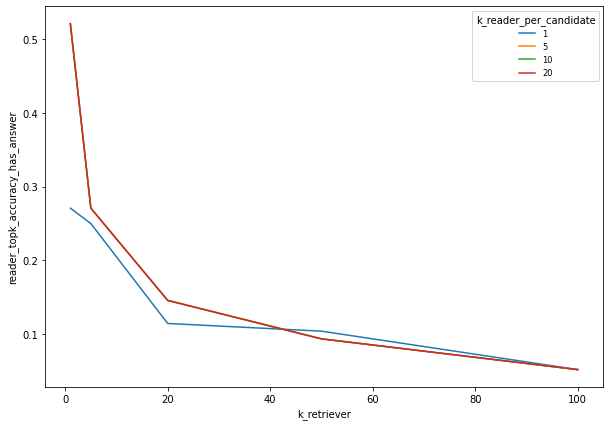

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
runs_5.set_index('k_retriever', inplace=True)
runs_5.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

### k_reader_total = 10

In [9]:
runs_10 = runs[runs['k_reader_total']==k_reader_total_tested[2]]

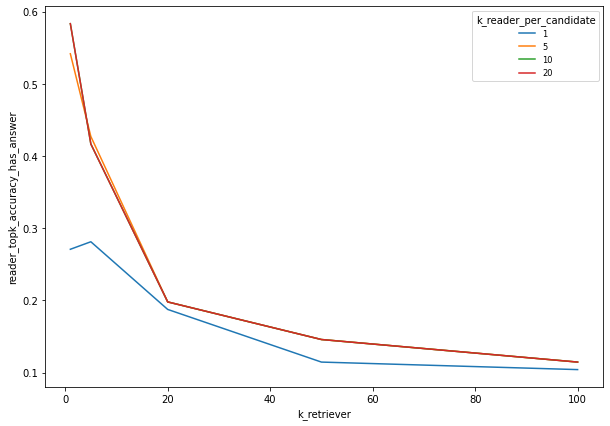

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
runs_10.set_index('k_retriever', inplace=True)
runs_10.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

### k_reader_total = 20

In [11]:
runs_20 = runs[runs['k_reader_total']==k_reader_total_tested[3]]

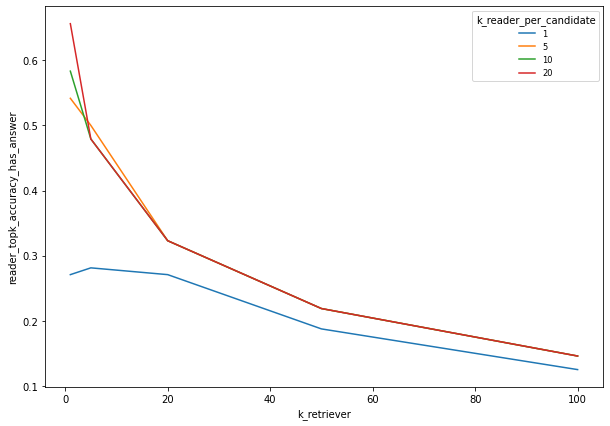

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
runs_20.set_index('k_retriever', inplace=True)
runs_20.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

## Influence sur top1_accuracy

### k_reader_total = 5

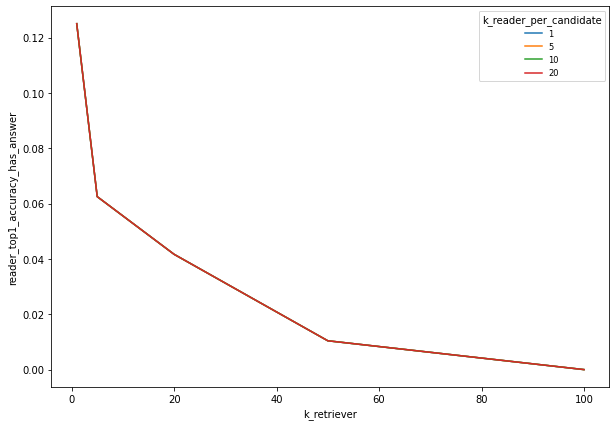

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
#runs_5.set_index('k_retriever', inplace=True)
runs_5.groupby('k_reader_per_candidate')['reader_top1_accuracy_has_answer'].plot(legend=True)
ax.set_ylabel('reader_top1_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

Dans la suite du notebook, nous fixons `k_reader_total` = `5`

# Analyse de l'influence des paramètres

In [14]:
y = runs['reader_topk_accuracy_has_answer']
X = runs[['k_reader_per_candidate', 'k_reader_total', 'k_retriever']]

In [15]:
poly = PolynomialFeatures(degree=3)
model = Ridge()

X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))

model.fit(X_poly,y)
model.score(X_poly,y)

0.9337542721038418

In [16]:
results = {name:coef for name, coef in zip(X_poly.columns, model.coef_)}
results = dict(sorted(results.items(), key=lambda item: abs(item[1]), reverse=True))
results

{'k_reader_per_candidate': 0.04505994164332884,
 'k_retriever': -0.019388559343942305,
 'k_reader_per_candidate^2': -0.00423993386693685,
 'k_reader_per_candidate k_reader_total': 0.0013516892834262418,
 'k_reader_total^2': 0.0007862905359211392,
 'k_reader_per_candidate k_retriever': -0.0005850140256961915,
 'k_retriever^2': 0.000412337955498976,
 'k_reader_total k_retriever': 0.00011581842481862127,
 'k_reader_per_candidate^3': 0.00011523497868154985,
 'k_reader_total': 7.872372559121172e-05,
 'k_reader_total^3': -3.31351822015593e-05,
 'k_reader_per_candidate^2 k_reader_total': -2.675441364713057e-05,
 'k_reader_per_candidate k_reader_total^2': -1.6037912319758377e-05,
 'k_reader_per_candidate^2 k_retriever': 1.2965200606031825e-05,
 'k_reader_per_candidate k_reader_total k_retriever': -3.7825905165711902e-06,
 'k_reader_per_candidate k_retriever^2': 2.600652888886576e-06,
 'k_retriever^3': -2.4083347556428644e-06,
 'k_reader_total^2 k_retriever': 1.5913355984064863e-06,
 'k_reader_

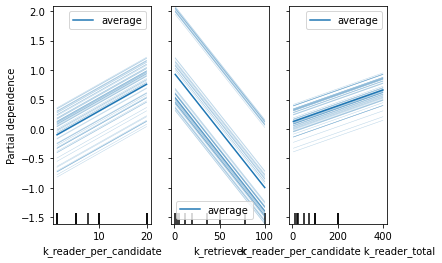

In [17]:
important_features = ['k_reader_per_candidate', 'k_retriever','k_reader_per_candidate k_reader_total']
plot_partial_dependence (model, X_poly, important_features, kind='both')

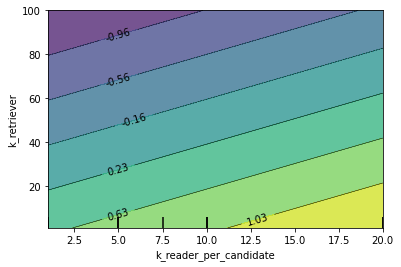

In [18]:
important_features = [('k_reader_per_candidate', 'k_retriever')]
plot_partial_dependence (model, X_poly, important_features)

## Analyse de l'influence des paramètres sur time_per_label

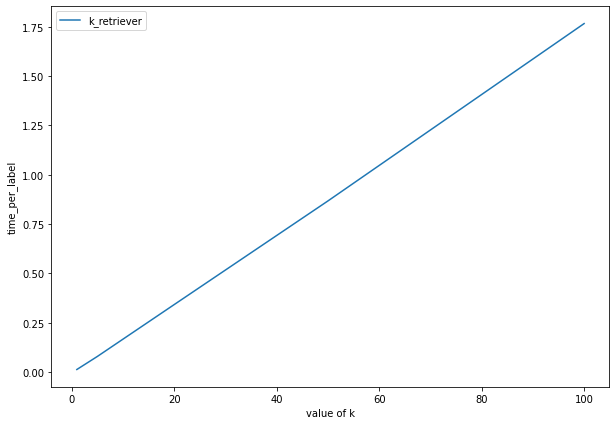

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
runs_5.groupby(by=['k_retriever']).mean()["time_per_label"].plot()
plt.legend(['k_retriever'], loc='upper left')
ax.set(xlabel='value of k', ylabel='time_per_label')
plt.show()

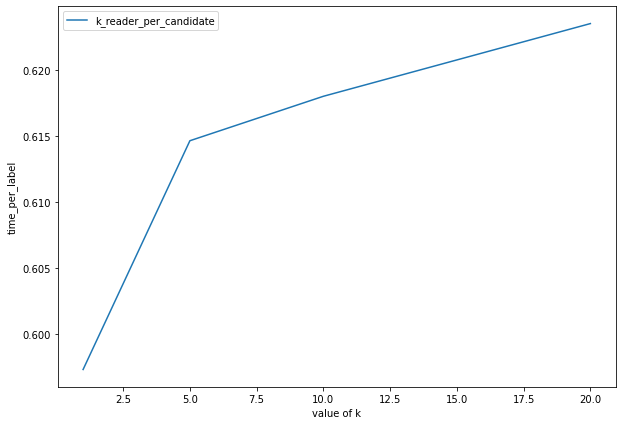

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
runs_5.groupby(by=['k_reader_per_candidate']).mean()["time_per_label"].plot()
plt.legend(['k_reader_per_candidate'], loc='upper left')
ax.set(xlabel='value of k', ylabel='time_per_label')
plt.show()

In [23]:
y = runs['time_per_label']
X = runs[['k_reader_per_candidate', 'k_reader_total', 'k_retriever']]

In [29]:
poly = PolynomialFeatures(degree=1)
model = Ridge()

X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(X.columns))

model.fit(X_poly,y)
model.score(X_poly,y)

0.9995642255000158

In [30]:
results = {name:coef for name, coef in zip(X_poly.columns, model.coef_)}
results = dict(sorted(results.items(), key=lambda item: abs(item[1]), reverse=True))
results

{'k_retriever': 0.01773383756927657,
 'k_reader_per_candidate': 0.001218475972594135,
 'k_reader_total': 5.539366014360576e-05,
 '1': 0.0}

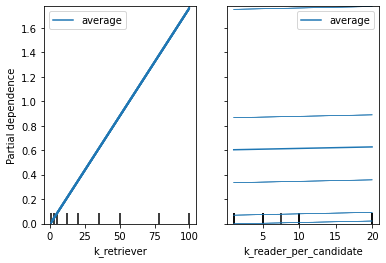

In [31]:
important_features = [ 'k_retriever','k_reader_per_candidate']
plot_partial_dependence (model, X_poly, important_features, kind='both')

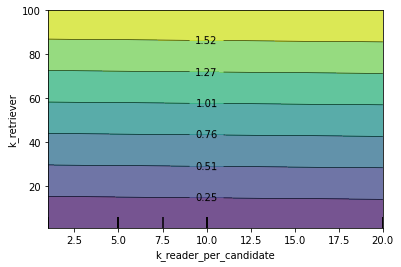

In [32]:
important_features = [('k_reader_per_candidate', 'k_retriever')]
plot_partial_dependence (model, X_poly, important_features)